# SMMD Loss Landscape & Descent Direction

This notebook visualizes the Sliced Maximum Mean Discrepancy (SMMD) loss landscape between two Gaussian distributions.
We fix a **Target Gaussian** $N(\mu_{target}, I)$ and vary the mean $\mu$ of a **Source Gaussian** $N(\mu, I)$.

We plot:
1. **Contour Lines**: The SMMD loss values in the 2D mean parameter space.
2. **Descent Direction**: The negative gradient of the SMMD loss with respect to the source mean ($-\nabla_\mu \text{SMMD}$), showing how SMMD guides the source distribution towards the target.

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
def sliced_mmd_loss(X, Y, num_slices=50, bandwidth=1.0):
    """
    Computes Sliced MMD between two sets of samples X and Y.
    X: (N, d) tensor
    Y: (M, d) tensor
    """
    N, d = X.shape
    M, _ = Y.shape
    
    # 1. Generate Random Slices (Projections)
    # Draw from unit sphere
    slices = torch.randn(d, num_slices, device=X.device)
    slices = slices / torch.norm(slices, dim=0, keepdim=True)
    
    # 2. Project Data
    # X_proj: (N, L)
    X_proj = torch.matmul(X, slices)
    # Y_proj: (M, L)
    Y_proj = torch.matmul(Y, slices)
    
    # 3. Compute 1D MMD with Gaussian Kernel on Projections
    # We compute pairwise squared differences efficiently via broadcasting
    
    # Expand dims for broadcasting: (N, 1, L) vs (1, N, L)
    X_exp = X_proj.unsqueeze(1)
    X_exp_T = X_proj.unsqueeze(0)
    
    # Kernel XX: (N, N, L)
    # dist_sq = (x-y)^2
    dist_XX = (X_exp - X_exp_T)**2
    K_XX = torch.exp(-0.5 * dist_XX / bandwidth**2)
    # Mean over N*N pairs -> (L,)
    loss_XX = K_XX.mean(dim=(0, 1))
    
    # Kernel YY
    Y_exp = Y_proj.unsqueeze(1)
    Y_exp_T = Y_proj.unsqueeze(0)
    dist_YY = (Y_exp - Y_exp_T)**2
    K_YY = torch.exp(-0.5 * dist_YY / bandwidth**2)
    loss_YY = K_YY.mean(dim=(0, 1))
    
    # Kernel XY
    # (N, 1, L) vs (1, M, L)
    X_exp_2 = X_proj.unsqueeze(1)
    Y_exp_2 = Y_proj.unsqueeze(0)
    dist_XY = (X_exp_2 - Y_exp_2)**2
    K_XY = torch.exp(-0.5 * dist_XY / bandwidth**2)
    loss_XY = K_XY.mean(dim=(0, 1))
    
    # Total SMMD per slice
    smmd_per_slice = loss_XX + loss_YY - 2 * loss_XY
    
    # Average over slices
    return smmd_per_slice.mean()

In [7]:
# ====================== Experiment Setup ======================

# 1. Define Target Distribution: N([0,0], I)
target_mean = torch.tensor([0.0, 0.0], device=device)
target_std = 0.5
n_samples = 500

# Generate fixed target samples
target_samples = torch.randn(n_samples, 2, device=device) * target_std + target_mean

# 2. Define Grid for Source Mean (Parameter Space)
grid_range = 3.0
grid_size = 20
x = np.linspace(-grid_range, grid_range, grid_size)
y = np.linspace(-grid_range, grid_range, grid_size)
X, Y = np.meshgrid(x, y)

# Store results
losses = np.zeros_like(X)
grads_u = np.zeros_like(X)
grads_v = np.zeros_like(X)

# 3. Compute Landscape
print("Computing SMMD landscape and gradients...")

# Fix source noise for smooth landscape (Reparameterization Trick)
# source = mu + noise * std
fixed_source_noise = torch.randn(n_samples, 2, device=device)
source_std = 0.5 # Same std as target to focus on mean shift

for i in range(grid_size):
    for j in range(grid_size):
        # Current Source Mean parameter
        mu_val = torch.tensor([X[i,j], Y[i,j]], device=device, requires_grad=True, dtype=torch.float32)
        
        # Generate Source Samples (differentiable w.r.t mu_val)
        source_samples = fixed_source_noise * source_std + mu_val
        
        # Compute Loss
        loss = sliced_mmd_loss(source_samples, target_samples, num_slices=50, bandwidth=0.5)
        
        # Backward pass to get gradient
        loss.backward()
        
        # Store Loss
        losses[i,j] = loss.item()
        
        # Store Descent Direction (-Gradient)
        # We want to show where the parameter should move to minimize loss
        grads_u[i,j] = -mu_val.grad[0].item()
        grads_v[i,j] = -mu_val.grad[1].item()

print("Computation complete.")

Computing SMMD landscape and gradients...
Computation complete.


<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
/var/folders/v3/zb8k14kn3hx6zpptgqbh5n0c0000gn/T/ipykernel_65416/1974099283.py:20: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Source Mean $\mu_x$', fontsize=12)
/var/folders/v3/zb8k14kn3hx6zpptgqbh5n0c0000gn/T/ipykernel_65416/1974099283.py:21: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Source Mean $\mu_y$', fontsize=12)


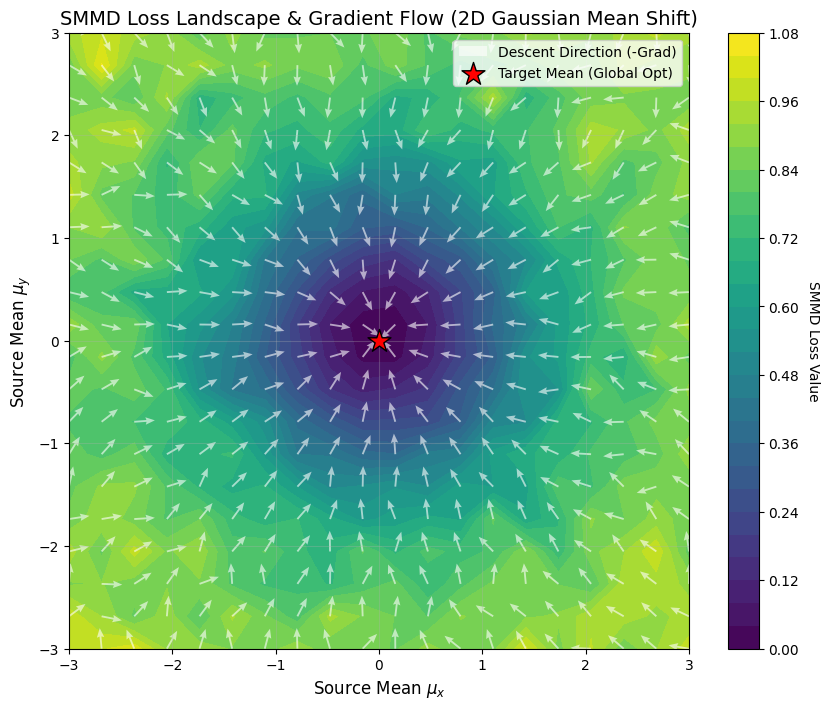

In [8]:
# ====================== Visualization ======================
plt.figure(figsize=(10, 8))

# 1. Plot Contour (Loss Landscape)
cp = plt.contourf(X, Y, losses, levels=25, cmap='viridis')
cbar = plt.colorbar(cp)
cbar.set_label('SMMD Loss Value', rotation=270, labelpad=15)

# 2. Plot Quiver (Descent Direction)
# Normalize arrows for better visualization
norm = np.sqrt(grads_u**2 + grads_v**2)
norm = np.where(norm == 0, 1, norm) # Avoid div by zero
plt.quiver(X, Y, grads_u/norm, grads_v/norm, color='white', alpha=0.6, 
           scale=30, headwidth=4, label='Descent Direction (-Grad)')

# 3. Mark Target Mean
plt.scatter([0], [0], c='red', marker='*', s=300, label='Target Mean (Global Opt)', zorder=10, edgecolors='black')

plt.title('SMMD Loss Landscape & Gradient Flow (2D Gaussian Mean Shift)', fontsize=14)
plt.xlabel('Source Mean $\mu_x$', fontsize=12)
plt.ylabel('Source Mean $\mu_y$', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.show()

### Analysis

The plot above demonstrates that **SMMD provides a smooth, convex-like landscape** for Gaussian mean estimation.
- The **contour lines** are roughly circular/elliptical, centering on the target mean $(0,0)$.
- The **gradient arrows** point directly towards the global minimum, indicating that SMMD provides informative gradients for optimization even when the distributions are far apart (unlike KL divergence which can vanish if support is disjoint, though Gaussians always overlap).

This confirms SMMD is an effective objective for matching distributions in generative modeling.